In [37]:
import zipfile
import shutil
from tensorflow.keras.utils import load_img, plot_model
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
import PIL
from PIL import Image
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
#import warnings
from tqdm.notebook import tqdm
#warnings.filterwarnings('ignore')

In [16]:
!unzip '/content/UTKface_inthewild-20240702T010559Z-001.zip'

Archive:  /content/UTKface_inthewild-20240702T010559Z-001.zip
  inflating: UTKface_inthewild/part1.tar.gz  
  inflating: UTKface_inthewild/part3.tar.gz  
  inflating: UTKface_inthewild/part2.tar.gz  


In [17]:
# Create base folder "faces" to store image set
# If folder does not exist, then create it
if not os.path.exists('/content/faces'):
    os.makedirs('/content/faces')

In [18]:
# Extract .jpg images from base folder to destination folder (faces)
!tar -xzvf "/content/UTKface_inthewild/part1.tar.gz" -C "/content/faces/"

Streaming output truncated to the last 5000 lines.
part1/14_0_2_20170103201051263.jpg
part1/30_1_0_20170104170158777.jpg
part1/62_0_0_20170104212928133.jpg
part1/27_1_0_20170103230354912.jpg
part1/65_1_0_20170110123252108.jpg
part1/60_1_0_20170110151441645.jpg
part1/44_1_3_20170109141426511.jpg
part1/62_0_3_20170104220837477.jpg
part1/25_1_0_20170111182452788.jpg
part1/10_1_0_20170109204244904.jpg
part1/27_1_0_20170105183939496.jpg
part1/1_0_2_20161219212557190.jpg
part1/9_0_0_20170110221659430.jpg
part1/67_1_0_20170110140730634.jpg
part1/62_1_0_20170110160643751.jpg
part1/1_1_3_20161220220534186.jpg
part1/39_0_2_20170104204400674.jpg
part1/27_1_3_20170104223400455.jpg
part1/37_0_4_20170104000748917.jpg
part1/2_0_2_20161219162357438.jpg
part1/2_0_2_20161219222714623.jpg
part1/52_0_2_20170104184356222.jpg
part1/60_1_0_20170110122626700.jpg
part1/32_1_0_20170103181503793.jpg
part1/41_0_0_20170109012220690.jpg
part1/1_0_4_20161221201411850.jpg
part1/60_0_0_20170111203255875.jpg
part1/1_1_

In [38]:
# Declare the base directory where image data is held
# Create empty lists to hold data
base_dir = '/content/faces/part1'
age_labels = []
gender_labels = []
image_paths = []

image_filenames = os.listdir(base_dir)
random.shuffle(image_filenames)

# Test print, ensure file names are present and in correct format
# print(image_filenames)

# Extract all image component features in data set
# Gender is index 0, Age is index 1)
for image in tqdm(image_filenames):
    image_path = os.path.join(base_dir, image)
    img_components = image.split('_')
    age_label = int(img_components[0])
    gender_label = int(img_components[1])

    # Appending the image_path, age label, and gender label into the associated list
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    image_paths.append(image_path)

  0%|          | 0/10137 [00:00<?, ?it/s]

In [39]:
# Test print, ensure data length is consistent across all extracted image features
# Should be 10137 (age labels, gender labels, and image paths)
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')

Number of age_labels: 10137, Number of gender_labels: 10137, Number of image_paths: 10137


In [40]:
# Designate gender mapping for ease of use
gender_mapping = {1: 'Female', 0: 'Male'}

In [41]:
# Establish DataFrame
# DF consists of the image_path, age, and gender
# Show first 5 data collections
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/faces/part1/10_0_0_20170110220403810.jpg,10,0
1,/content/faces/part1/39_0_0_20170104170046913.jpg,39,0
2,/content/faces/part1/35_1_2_20170109010122762.jpg,35,1
3,/content/faces/part1/45_0_4_20170103235240356.jpg,45,0
4,/content/faces/part1/39_0_0_20170104174316011.jpg,39,0


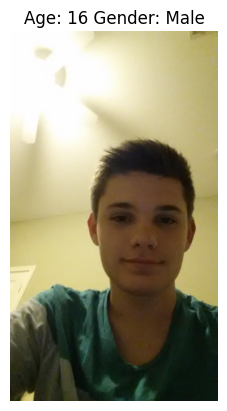

In [42]:
# Create random index to pull an image from collection
rand_index = random.randint(0, len(image_paths))
age = df['age'][rand_index]
gender = df['gender'][rand_index]
# Open image and title it using the labeled Age/Gender data
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)

In [43]:
# Setting up the image features list and image normalization
def extract_image_features(images):
  features = list()

  for image in tqdm(images):
    img = load_img(image, grayscale=True)
    img = img.resize((128, 128), PIL.Image.LANCZOS)
    img = np.array(img)
    features.append(img)

  features = np.array(features)
  features = features.reshape(len(features), 128, 128, 1)

  return features

In [44]:
# Extract features from all images in UTKFace data set
X = extract_image_features(df['image_path'])

  0%|          | 0/10137 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [45]:
# Verify the shape of X (target = 10137, 128, 128, 1)
X.shape

(10137, 128, 128, 1)

In [46]:
# Normalize each image
X = X / 255.0

In [47]:
# Define the two image outputs (from project scope)
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [48]:
# Define input shape for CNN
input_shape = (128, 128, 1)

In [49]:
# Apply CNN filters to image
inputs = Input((input_shape))
conv1 = Conv2D(16, (3, 3), activation='relu')(inputs)
max1 = MaxPooling2D(2, 2)(conv1)
conv2 = Conv2D(32, (3, 3), activation='relu')(max1)
max2 = MaxPooling2D(2, 2)(conv2)
conv3 = Conv2D(64, (3, 3), activation='relu')(max2)
max3 = MaxPooling2D(2, 2)(conv3)
conv4 = Conv2D(128, (3, 3), activation='relu')(max3)
max4 = MaxPooling2D(2, 2)(conv4)
conv5 = Conv2D(256, (3, 3), activation='relu')(max4)
max5 = MaxPooling2D(2, 2)(conv5)

flatten = Flatten()(max5)

# Two Fully Connected Layers (one for each output, age and gender)
dense1 = Dense(256, activation='relu')(flatten)
dense2 = Dense(256, activation='relu')(flatten)

# Two Dropout Layers (one for each output, age and gender)
dropout1 = Dropout(0.25)(dense1)
dropout2 = Dropout(0.25)(dense2)

# Use sigmoid activation because gender value is binary
output1 = Dense(1, activation='sigmoid', name='gender_out')(dropout1)
# Use relu activation because age is an estimated value
output2 = Dense(1, activation='relu', name='age_out')(dropout2)

model = Model(inputs=[inputs], outputs=[output1, output2])
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

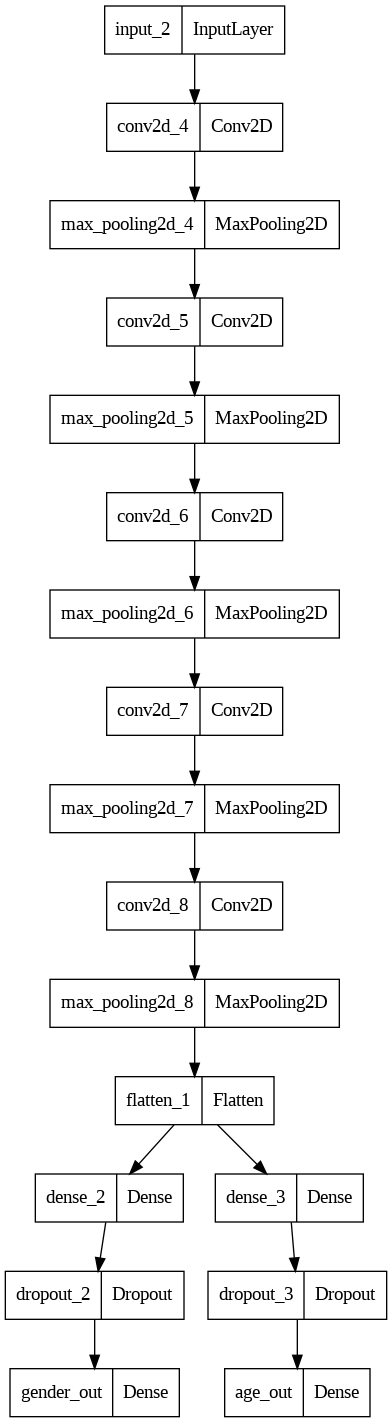

In [50]:
# Plot Model
# Shows split for both outputs after the Flatten layer
plot_model(model)

In [51]:
runtime = model.fit(x=X, y=[y_gender, y_age], batch_size=16, epochs=20, validation_split=0.2)

Epoch 1/20
507/507 [==============================] - 9s 12ms/step - loss: 20.9508 - gender_out_loss: 0.7027 - age_out_loss: 20.2481 - gender_out_accuracy: 0.5369 - age_out_accuracy: 0.1253 - val_loss: 21.1232 - val_gender_out_loss: 0.6846 - val_age_out_loss: 20.4386 - val_gender_out_accuracy: 0.5503 - val_age_out_accuracy: 0.1238
Epoch 2/20
507/507 [==============================] - 5s 10ms/step - loss: 19.6855 - gender_out_loss: 0.6858 - age_out_loss: 18.9996 - gender_out_accuracy: 0.5568 - age_out_accuracy: 0.1258 - val_loss: 18.6240 - val_gender_out_loss: 0.6828 - val_age_out_loss: 17.9412 - val_gender_out_accuracy: 0.5572 - val_age_out_accuracy: 0.1238
Epoch 3/20
507/507 [==============================] - 4s 8ms/step - loss: 19.0838 - gender_out_loss: 0.6846 - age_out_loss: 18.3992 - gender_out_accuracy: 0.5615 - age_out_accuracy: 0.1254 - val_loss: 17.8300 - val_gender_out_loss: 0.6776 - val_age_out_loss: 17.1524 - val_gender_out_accuracy: 0.5582 - val_age_out_accuracy: 0.1238
Ep

In [52]:
def get_img_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), PIL.Image.LANCZOS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0

  return img

In [35]:
# Creating test image folder
# If folder does not exist, then create it
# Here you can store any image you would like to test
if not os.path.exists('/content/Test_Images'):
    os.makedirs('/content/Test_Images')

1/1 [==============================] - 0s 416ms/step


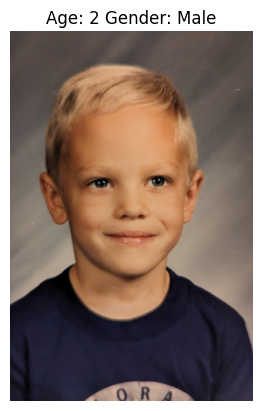

In [53]:
# Verify model accuracy using unlabeled image
# using img1.jpg - you will see a certain someone in his youth!
test_image = '/content/Test_Images/img1.jpg'

features = get_img_features(test_image)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Age: {age} Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(test_image)))